In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import cv2
import glob
from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

Using TensorFlow backend.


In [2]:
data_path = '..\\Data\\CK+\\cohn-kanade-images'
emotion_path = '..\\Data\\CK+\\Emotion'
facs_path = '..\\Data\\CK+\\FACS'
landmarks_path = '..\\Data\\CK+\\Landmarks'
crop_path = '..\\Data\\CK+\\Crop'

all_image_files = glob.glob(data_path+'/**/*.png', recursive=True)
all_emotion_files = glob.glob(emotion_path+'/**/*.txt', recursive=True)
all_facs_files = glob.glob(facs_path+'/**/*.txt', recursive=True)
all_landmarks_files = glob.glob(landmarks_path+'/**/*.txt', recursive=True)

In [3]:
# ONLY 327 of the 593 sequences have emotion sequences
# 0-7 (i.e. 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise)
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
all_image_files[:6], all_emotion_files[:6], all_facs_files[:6], all_landmarks_files[:6]

(['..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000002.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000003.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000004.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000005.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000006.png'],
 ['..\\Data\\CK+\\Emotion\\S005\\001\\S005_001_00000011_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\002\\S010_002_00000014_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\004\\S010_004_00000019_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\006\\S010_006_00000015_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S011\\001\\S011_001_00000016_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S011\\002\\S011_002_00000022_emotion.txt'],
 ['..\\Data\\CK+\\FACS\\S005\\001\\S005_001_00000011_facs.txt',
  '..\\Data\\CK+\\FACS\\S010\\001\\S010_001_00000014_facs.txt',
  '..\\Data\

In [5]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [6]:
pd.set_option('display.max_colwidth', -1)

crop_imsize = 350

def get_thumbnail(path):
    ''' function to read image'''
    i = Image.open(path)
#     i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    ''' function to encode image in base64 '''
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    ''' function to return html code for printing image in dataframe '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(im))

def crop_image_formatter(im):
    ''' function to read cropped image from numpy array '''
    return '<img src="data:image/jpeg;base64,{}">'.format(image_base64(Image.fromarray(np.uint8(im))))

face_det = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

def print_metrics(y_test, y_pred):
    ''' just a function from data science for printing '''
    labels = dict(all_emotions)
    del labels[0]
    
    print(labels)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Classification Report: \n', classification_report(y_test, y_pred, 
                                                             target_names=[l for l in labels.values()]))
    
    conf_mat = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)

    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(len(labels)), [l for l in labels.values()], rotation=90)
    _ = plt.yticks(range(len(labels)), [l for l in labels.values()])

In [7]:
# reading all the image files, and then finding corresponding landmark, facs files and save them in a dictionary
image_dict = {}

for i_im in all_image_files:
    im_dict = {}
    im_folder = i_im.rsplit('\\', 1)[0]
    #print(im_folder)
    
    if im_folder not in image_dict.keys():
        im_files = glob.glob(im_folder+'/*.png')
        #print(i_im)
        #print(im_files)
        #print(im_folder)
        im_dict['emotion'] = im_files[-1]
        #print(im_files[-1])
        im_dict['neutral'] = im_files[0]
        #print(im_files[0])

        im_folder_base = im_files[-1].split('\\', 4)[-1].rsplit('\\', 1)[0]
        #print(im_folder_base)
        facs_folder = facs_path + '\\' + im_folder_base 
        emotion_folder = emotion_path + '\\'+ im_folder_base
        landmarks_folder = landmarks_path + '\\'+ im_folder_base
        #print(facs_folder)
        facs_file = glob.glob(facs_folder+'/*.txt')[0]
        emotion_file = glob.glob(emotion_folder+'/*.txt')
        neutral_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[0]
        emotion_landmarks_file = glob.glob(landmarks_folder+'/*.txt')[-1]

        with open(facs_file) as f:
            data = f.read()
            im_dict['facs'] = np.array([list(map(float, i.split())) for i in data.strip().split('\n')])

        if len(emotion_file) > 0:
            emotion_file = emotion_file[0]
            with open(emotion_file) as f:
                data = f.read()
                im_dict['label'] = int(float(data))
                im_dict['label_str'] = all_emotions[im_dict['label']]

        with open(neutral_landmarks_file) as f:
            data = f.read()
            im_dict['neutral_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

        with open(emotion_landmarks_file) as f:
            data = f.read()
            im_dict['emotion_landmarks'] = np.array([list(map(float, 
                                                     i.split())) for i in data.strip().split('\n')])

    #     print(im_dict)
        image_dict[im_folder] = (im_dict)


In [8]:
# converting that dictionary to pandas dataframe, and applying operations on certain columns
df_images = pd.DataFrame.from_dict(image_dict).T
df_images.to_csv('ImageDict.csv', index=False)

In [9]:


# function to store images in df column
df_images['im_emotion'] = df_images.emotion.map(lambda f: get_thumbnail(f))
df_images['im_neutral'] = df_images.neutral.map(lambda f: get_thumbnail(f))

# function to detect faces and crop images and store in df, and also shift landmarks to cropped face
# df_images['im_emotion_crop'] = df_images.emotion.map(lambda f: detect_face(f))
# df_images['im_neutral_crop'] = df_images.neutral.map(lambda f: detect_face(f))
emotion_crop_tuple = df_images.apply(lambda row: detect_face(row.emotion, 
                                                             row.emotion_landmarks), axis=1)
df_images[['im_emotion_crop', 'emotion_crop_landmarks']] = pd.DataFrame(emotion_crop_tuple.tolist(), index=emotion_crop_tuple.index)
neutral_crop_tuple = df_images.apply(lambda row: detect_face(row.neutral, 
                                                             row.neutral_landmarks), axis=1)
df_images[['im_neutral_crop', 'neutral_crop_landmarks']] = pd.DataFrame(neutral_crop_tuple.tolist(), index=neutral_crop_tuple.index)

df_images.head(3)

emotion  \
..\Data\CK+\cohn-kanade-images\S005\001  ..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000011.png   
..\Data\CK+\cohn-kanade-images\S010\001  ..\Data\CK+\cohn-kanade-images\S010\001\S010_001_00000014.png   
..\Data\CK+\cohn-kanade-images\S010\002  ..\Data\CK+\cohn-kanade-images\S010\002\S010_002_00000014.png   

                                                                                               neutral  \
..\Data\CK+\cohn-kanade-images\S005\001  ..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000001.png   
..\Data\CK+\cohn-kanade-images\S010\001  ..\Data\CK+\cohn-kanade-images\S010\001\S010_001_00000001.png   
..\Data\CK+\cohn-kanade-images\S010\002  ..\Data\CK+\cohn-kanade-images\S010\002\S010_002_00000001.png   

                                                                                                    facs  \
..\Data\CK+\cohn-kanade-images\S005\001  [[9.0, 4.0], [17.0, 2.0]]                                         
..\Data\CK+\cohn-kanade-images\S010\001  [[1.0, 0.0], [2.0, 0.0], [20.0, 0.0], [21.0, 0.0], [25.0, 0.0]]   
..\Data\CK+\cohn-kanade-images\S010\002  [[1.0, 0.0], [2.0, 0.0], [5.0, 0.0], [25.0, 0.0], [27.0, 0.0]]    

                                        label label_str  \
..\Data\CK+\cohn-kanade-images\S005\001  3     disgust    
..\Data\CK+\cohn-kanade-images\S010\001  NaN   NaN        
..\Data\CK+\cohn-kanade-images\S010\002  7     surprise   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            neutral_landmarks  \
..\Data\CK+\cohn-kanade-images\S005\001  [[217.79878, 217.08728], [216.89078, 254.86311], [223.67206, 292.07462], [238.23885, 326.79248], [254.94789, 360.61587], [279.53139, 388.90414], [310.45043, 410.4245], [345.37818, 425.29204], [382.36266, 428.5127], [418.06689, 424.13911], [449.99561, 408.56366], [477.42884, 385.63278], [499.83194, 357.7259], [509.4947, 323.37268], [516.13174, 287.86876], [518.15853, 252.06194], [518.69634, 216.55158], [247.6201, 180.34162], [268.70792, 165.39026], [293.56778, 158.93545], [319.16937, 160.78699], [343.48894, 169.15112], [397.25624, 164.28431], [420.26527, 156.48688], [443.57508, 150.79923], [467.19522, 154.8427], [488.87233, 165.42594], [372.77664, 199.50671], [373.99586, 223.36618], [375.57578, 246.90136], [378.10595, 270.34028], [345.61168, 293.24677], [361.62731, 300.03883], [378.63337, 301.76439], [393.55789, 298.57543], [406.85187, 291.64665], [280.10863

,label,im_neutral,im_neutral_crop,im_emotion,im_emotion_crop
..\Data\CK+\cohn-kanade-images\S005\001,3,,,,
..\Data\CK+\cohn-kanade-images\S010\001,NaN,,,,
..\Data\CK+\cohn-kanade-images\S010\002,7,,,,
..\Data\CK+\cohn-kanade-images\S010\003,NaN,,,,
..\Data\CK+\cohn-kanade-images\S010\004,1,,,,

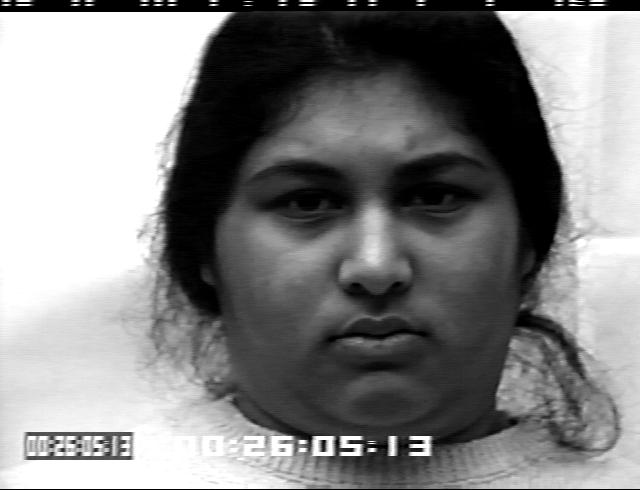
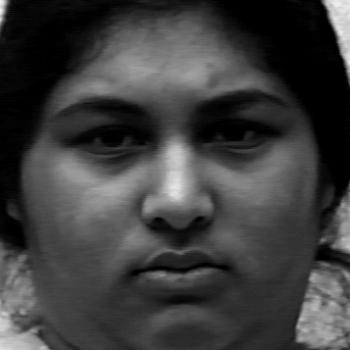
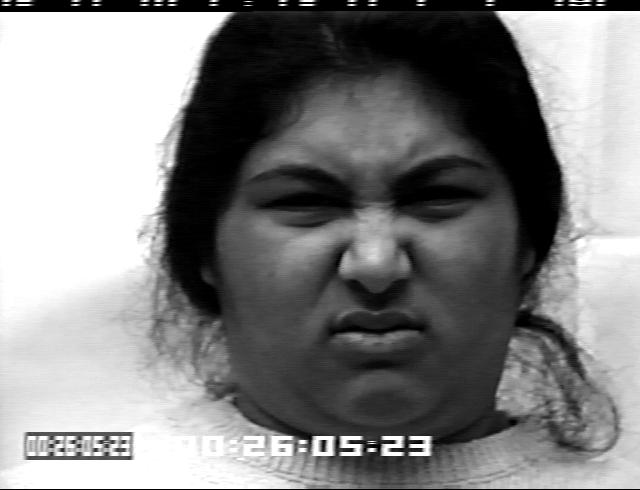
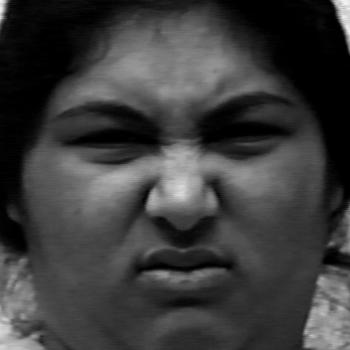
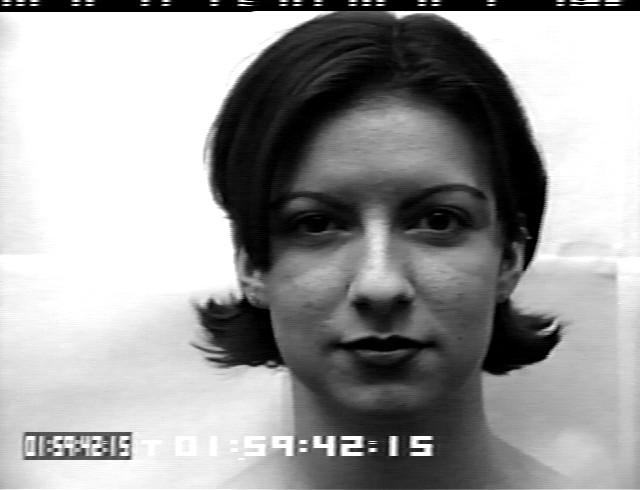
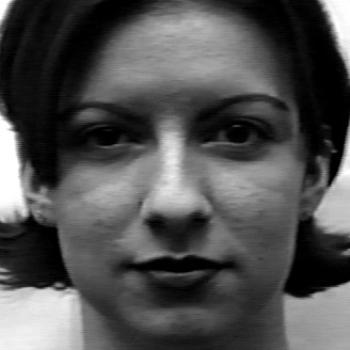
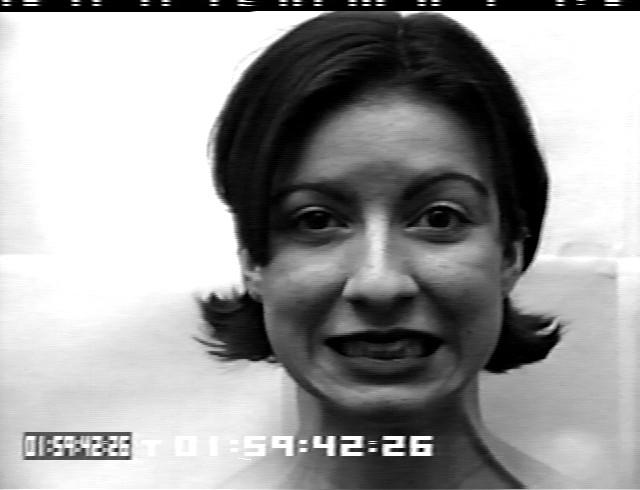
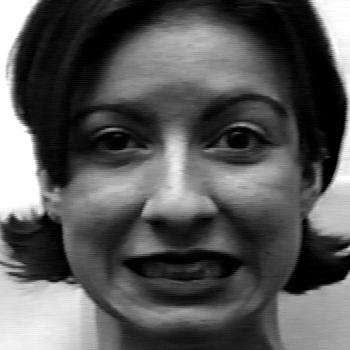
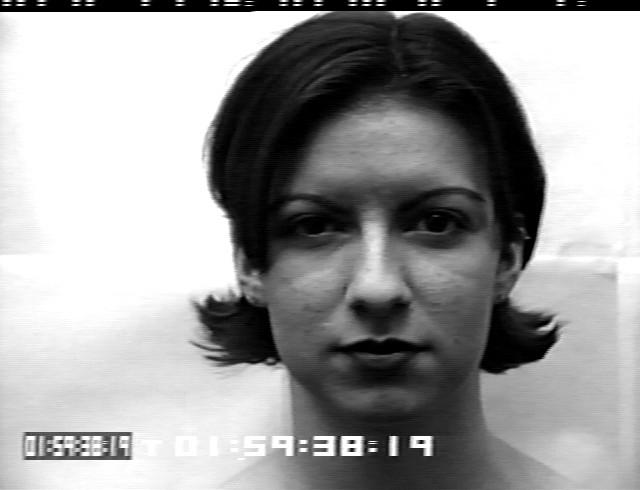
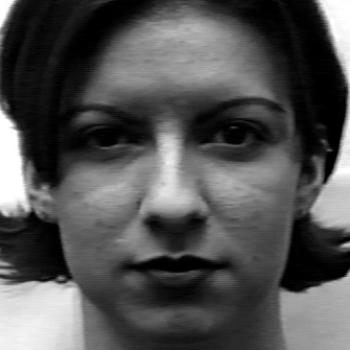
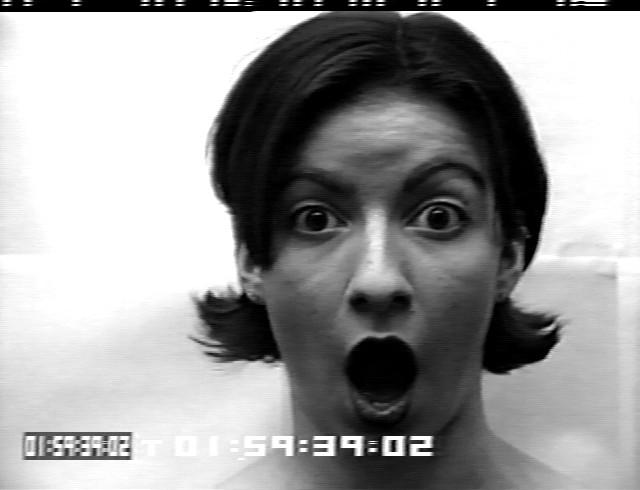
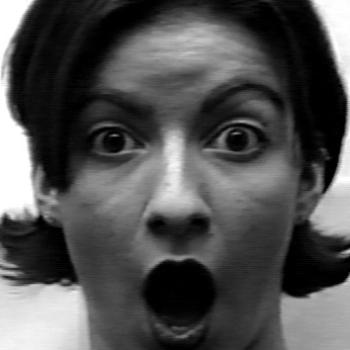
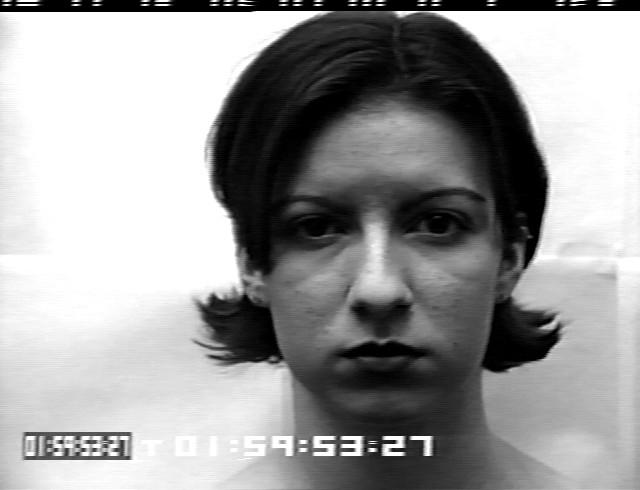
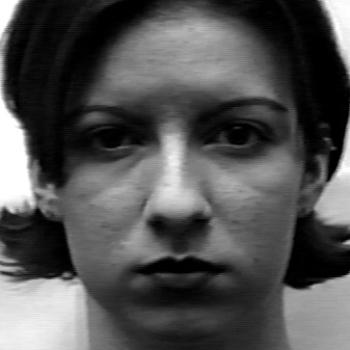
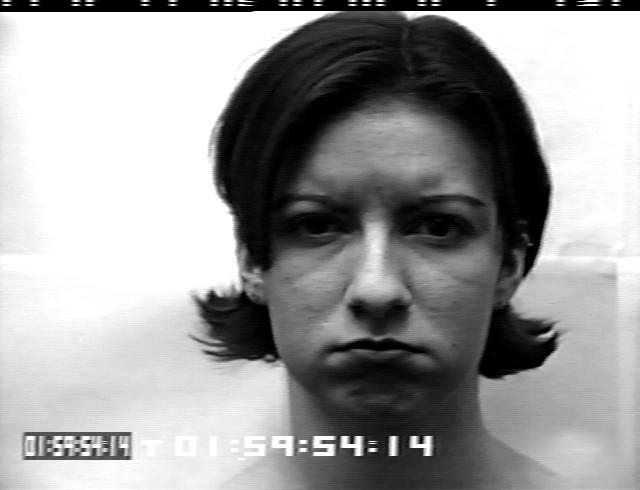
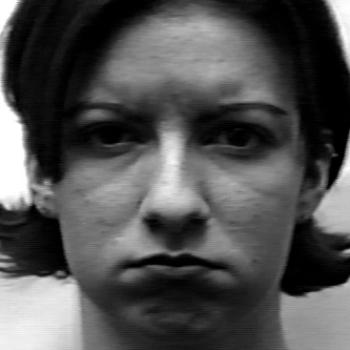
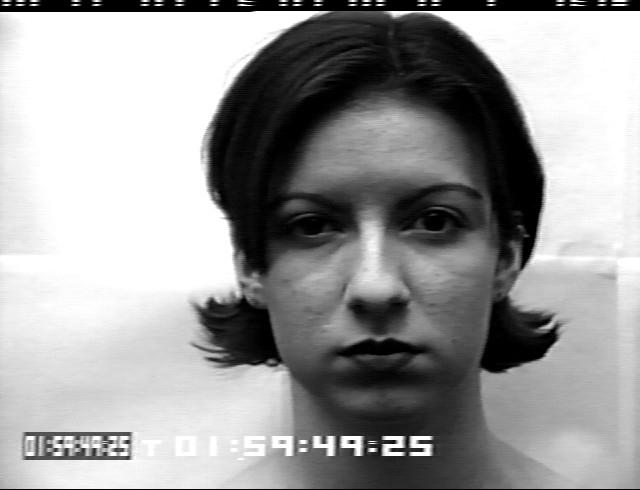
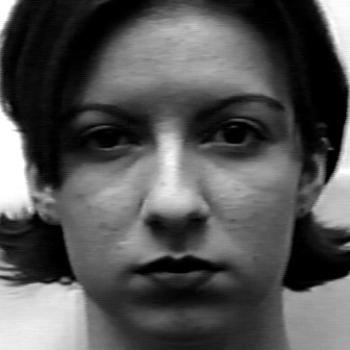
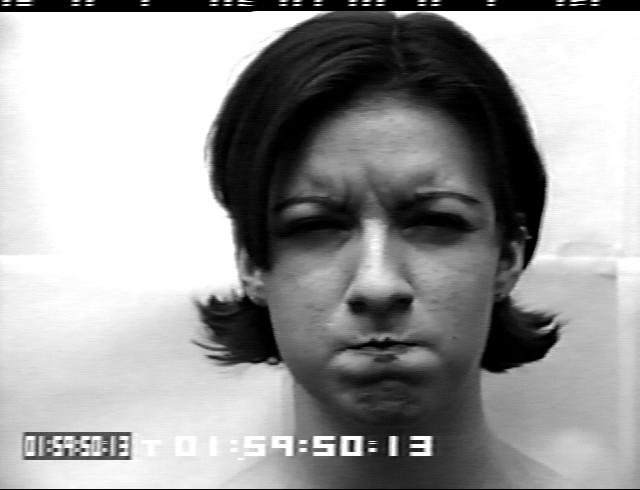
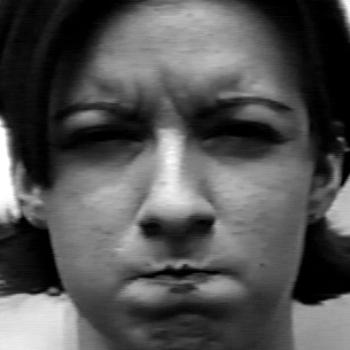

In [10]:
# displaying PIL.Image objects embedded in dataframe
HTML(df_images[['label', 'im_neutral', 'im_neutral_crop', 'im_emotion', 
                'im_emotion_crop']].head(5).to_html(formatters={'im_neutral': image_formatter, 
                                                                'im_emotion': image_formatter,
                                                                'im_neutral_crop': crop_image_formatter, 
                                                                'im_emotion_crop': crop_image_formatter}, escape=False))
# HTML(image_formatter(df_images[['im_neutral']].head(1)['im_neutral'][0]))
# df_images[['im_neutral']].head(1)['im_neutral'][0]

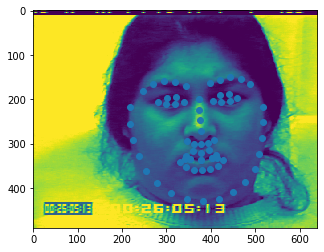

In [11]:
ld, im = df_images.head(1)[['neutral_landmarks', 'neutral']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

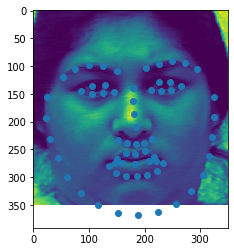

In [12]:
ld, im = df_images.head(1)[['neutral_crop_landmarks', 'im_neutral_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

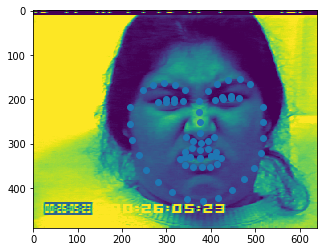

In [13]:
ld, im = df_images.head(1)[['emotion_landmarks', 'emotion']].values[0]
implot = plt.imshow(Image.open(im))

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

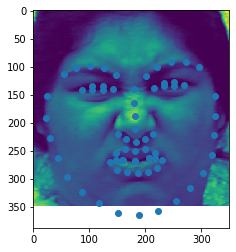

In [14]:
ld, im = df_images.head(1)[['emotion_crop_landmarks', 'im_emotion_crop']].values[0]
implot = plt.imshow(im)

plt.scatter([ld[i][0] for i in range(68)], [ld[i][1] for i in range(68)])
plt.show()

In [15]:
df_cnn = df_images[~df_images['label'].isna()][['im_emotion_crop', 'label']]

In [16]:
X, y = df_cnn['im_emotion_crop'], df_cnn['label']

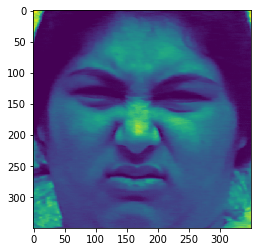

In [17]:
X_flip = X.apply(lambda x: np.fliplr(x))
plt.imshow(X_flip[0])

In [18]:
X_total = pd.concat([X.reset_index(drop=True), X_flip.reset_index(drop=True)], axis=0).reset_index(drop=True)
X_total = np.array([i for i in X_total])
print(X_total.shape)
X_total = X_total.reshape(X_total.shape[0], crop_imsize, crop_imsize, 1)
y_total = to_categorical(pd.concat([y, y], axis=0).reset_index(drop=True))

X_total.shape, y_total.shape

(654, 350, 350)


((654, 350, 350, 1), (654, 8))

In [27]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((523, 350, 350, 1), (131, 350, 350, 1), (523, 8), (131, 8))

# Load the pre-trained FaceNet model

In [4]:
model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


# Pre-processing stages for using the FaceNet model

In [6]:
# load image from file
image = Image.open("..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png")
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
pixels = np.asarray(image)


In [7]:
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

**The following code assumes that there is only one face per picture** 

In [7]:
x1, y1, width, height = results[0]['box']

x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height

In [8]:
face = pixels[y1:y2, x1:x2]

In [9]:
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((160, 160))
face_array = np.asarray(image)

# Result of cropping using the MTCNN model

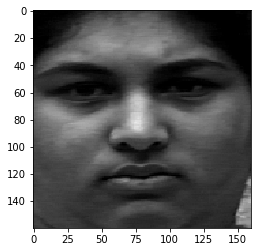

In [10]:
plt.imshow(face_array)

In [8]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# Result of cropping on some train set images  

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


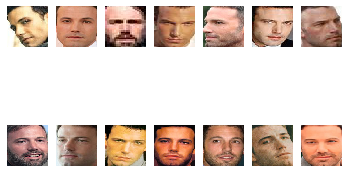

In [13]:
folder = '..\\Data\\5-celebrity-faces-dataset\\train\\ben_afflek\\'
i = 1
# enumerate files
for filename in os.listdir(folder):
    # path
    path = folder + filename
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    plt.subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

In [14]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in os.listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in os.listdir(directory):
        # path
        path = directory + subdir + '\\'
        # skip any files that might be in the dir
        if not os.path.isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [35]:
# load train dataset
trainX, trainy = load_dataset('..\\Data\\5-celebrity-faces-dataset\\train\\')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('..\\Data\\5-celebrity-faces-dataset\\val\\')
# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling


In [42]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [6]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [44]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

(93, 128)


In [45]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

(25, 128)


In [43]:
# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Predicted: elton_john (92.765)
Expected: elton_john


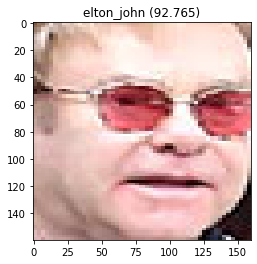

In [2]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_celeb = SVC(kernel='linear', probability=True)
model_celeb.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model_celeb.predict(samples)
yhat_prob = model_celeb.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000001.png
1 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000002.png
2 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000003.png
3 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000004.png
4 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000005.png
5 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000006.png
6 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000007.png
7 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000008.png
8 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000009.png
9 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000010.png
10 (160, 160, 3)
..\Data\CK+\cohn-kanade-images\S005\001\S005_001_00000011.png
11 (160, 160, 3)


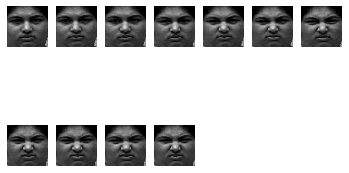

In [10]:
folder = '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\'
i = 1
# enumerate files
for filename in os.listdir(folder):
    # path
    path = folder + filename
    print(path)
    # get face
    face = extract_face(path)
    print(i, face.shape)
    # plot
    plt.subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(face)
    i += 1
plt.show()

# No face warping pipeline

In [25]:
data_path = '..\\Data\\CK+\\cohn-kanade-images'
emotion_path = '..\\Data\\CK+\\Emotion'
facs_path = '..\\Data\\CK+\\FACS'
landmarks_path = '..\\Data\\CK+\\Landmarks'
crop_path = '..\\Data\\CK+\\Crop'

all_image_files = glob.glob(data_path+'/**/*.png', recursive=True)
all_emotion_files = glob.glob(emotion_path+'/**/*.txt', recursive=True)
all_facs_files = glob.glob(facs_path+'/**/*.txt', recursive=True)
all_landmarks_files = glob.glob(landmarks_path+'/**/*.txt', recursive=True)

In [26]:
# ONLY 327 of the 593 sequences have emotion sequences
# 0-7 (i.e. 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise)
all_emotions = {0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 
                4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}
all_image_files[:6], all_emotion_files[:6], all_facs_files[:6], all_landmarks_files[:6]

(['..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000002.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000003.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000004.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000005.png',
  '..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000006.png'],
 ['..\\Data\\CK+\\Emotion\\S005\\001\\S005_001_00000011_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\002\\S010_002_00000014_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\004\\S010_004_00000019_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S010\\006\\S010_006_00000015_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S011\\001\\S011_001_00000016_emotion.txt',
  '..\\Data\\CK+\\Emotion\\S011\\002\\S011_002_00000022_emotion.txt'],
 ['..\\Data\\CK+\\FACS\\S005\\001\\S005_001_00000011_facs.txt',
  '..\\Data\\CK+\\FACS\\S010\\001\\S010_001_00000014_facs.txt',
  '..\\Data\

In [33]:
len(all_image_files)

10708

In [67]:
def detect_face(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
        
    
        image = Image.fromarray(gray)
        image = image.resize(required_size)
        image = image.convert('RGB')
        face_array = np.asarray(image)
    return face_array
    
    


## Pre-processing Data-set

In [41]:
faces_ck = list()
labels_ck  = list()
tmp_lab_prev = ''
tmp_lab = ''
for i in range(len(all_image_files)):
    i_im = all_image_files[i]
    tmp_lab = i_im.split('\\')[4]
    if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    face = detect_face(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab
    

Started pre-processing with subject:S005
Started pre-processing with subject:S010
Started pre-processing with subject:S011
Started pre-processing with subject:S014
Started pre-processing with subject:S022
Started pre-processing with subject:S026
Started pre-processing with subject:S028
Started pre-processing with subject:S029
Started pre-processing with subject:S032
Started pre-processing with subject:S034
Started pre-processing with subject:S035
Started pre-processing with subject:S037
Started pre-processing with subject:S042
Started pre-processing with subject:S044
Started pre-processing with subject:S045
Started pre-processing with subject:S046
Started pre-processing with subject:S050
Started pre-processing with subject:S051
Started pre-processing with subject:S052
Started pre-processing with subject:S053
Started pre-processing with subject:S054
Started pre-processing with subject:S055
Started pre-processing with subject:S056
Started pre-processing with subject:S057
Started pre-proc

In [42]:
X_full_ck = np.asarray(faces_ck)

In [43]:
l_full_ck = np.asarray(labels_ck)

In [44]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_full_ck, l_full_ck, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8566, 160, 160, 3), (2142, 160, 160, 3), (8566,), (2142,))

In [45]:
# save arrays to one file in compressed format
np.savez_compressed('ck+dataset.npz', X_train, y_train, X_test, y_test)

In [58]:
# load the face dataset
data = np.load('ck+dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (8566, 160, 160, 3) (8566,) (2142, 160, 160, 3) (2142,)


## Generate embeddings for each face in the data-set

In [61]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in range(trainX.shape[0]):
    face_pixels = trainX[i]
    embedding = get_embedding(model, face_pixels)
    if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

Processed 100 faces
Processed 200 faces
Processed 300 faces
Processed 400 faces
Processed 500 faces
Processed 600 faces
Processed 700 faces
Processed 800 faces
Processed 900 faces
Processed 1000 faces
Processed 1100 faces
Processed 1200 faces
Processed 1300 faces
Processed 1400 faces
Processed 1500 faces
Processed 1600 faces
Processed 1700 faces
Processed 1800 faces
Processed 1900 faces
Processed 2000 faces
Processed 2100 faces
Processed 2200 faces
Processed 2300 faces
Processed 2400 faces
Processed 2500 faces
Processed 2600 faces
Processed 2700 faces
Processed 2800 faces
Processed 2900 faces
Processed 3000 faces
Processed 3100 faces
Processed 3200 faces
Processed 3300 faces
Processed 3400 faces
Processed 3500 faces
Processed 3600 faces
Processed 3700 faces
Processed 3800 faces
Processed 3900 faces
Processed 4000 faces
Processed 4100 faces
Processed 4200 faces
Processed 4300 faces
Processed 4400 faces
Processed 4500 faces
Processed 4600 faces
Processed 4700 faces
Processed 4800 faces
P

In [62]:
# convert each face in the test set to an embedding
newTestX = list()
for i in range(testX.shape[0]):
    face_pixels = testX[i]
    embedding = get_embedding(model, face_pixels)
    if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

Processed 100 faces
Processed 200 faces
Processed 300 faces
Processed 400 faces
Processed 500 faces
Processed 600 faces
Processed 700 faces
Processed 800 faces
Processed 900 faces
Processed 1000 faces
Processed 1100 faces
Processed 1200 faces
Processed 1300 faces
Processed 1400 faces
Processed 1500 faces
Processed 1600 faces
Processed 1700 faces
Processed 1800 faces
Processed 1900 faces
Processed 2000 faces
Processed 2100 faces
(2142, 128)


In [63]:
# save arrays to one file in compressed format
np.savez_compressed('ck+-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

## Train an SVM model to recognize the faces

In [4]:
# load faces
data = load('ck+dataset.npz')
test_num = 660
train_num = 1340
testX_faces = data['arr_2'][:test_num]
# load face embeddings
data = load('ck+-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'][:train_num], data['arr_1'][:train_num], data['arr_2'][:test_num], data['arr_3'][:test_num]

testX = testX[testy != 'S005']
testX_faces = testX_faces[testy != 'S005']
testy = testy[testy != 'S005']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVM = SVC(gamma=2, C=1, probability=True)
model_SVM.fit(trainX, trainy)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Performance Evaluation

In [5]:
# prediction accuracy for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy (test set) = "+str(yhat_accuracy * 100) + " %")

Accuracy (test set) = 100.0 %


In [6]:
y_pred_shape_free = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_shape_free)
c_mat_val

array([[6, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 8, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 9, 0],
       [0, 0, 0, ..., 0, 0, 9]], dtype=int64)

In [7]:
print(classification_report(testy, y_pred_shape_free))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         5
          17       1.00    

## Results of the model on some randomly sampled examples from test set

554
Predicted: S079 (4.390)
Expected: S079


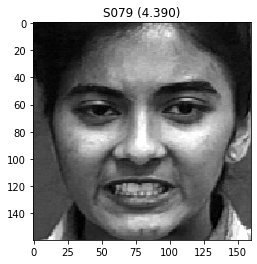

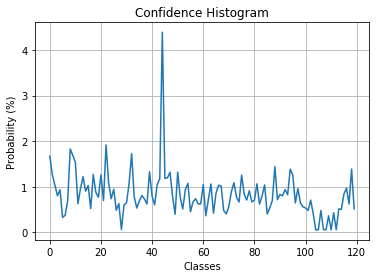

573
Predicted: S134 (9.569)
Expected: S134


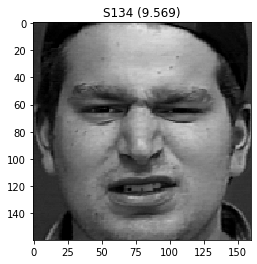

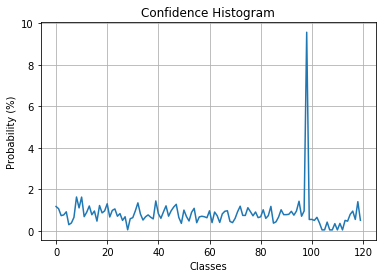

33
Predicted: S102 (15.692)
Expected: S102


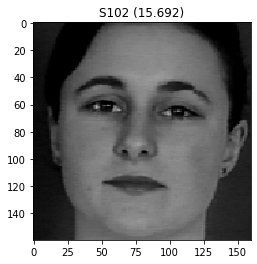

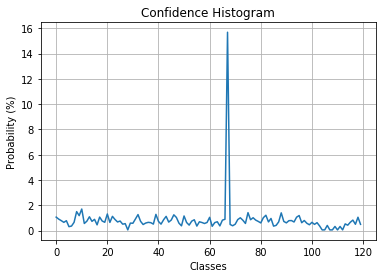

202
Predicted: S124 (13.498)
Expected: S124


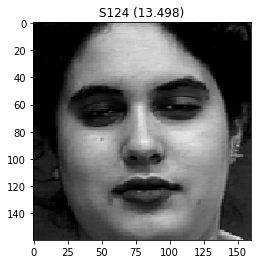

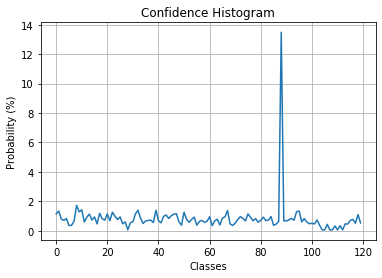

232
Predicted: S072 (9.241)
Expected: S072


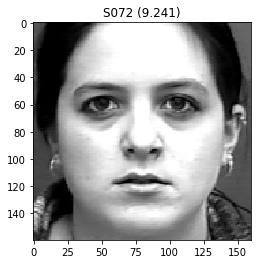

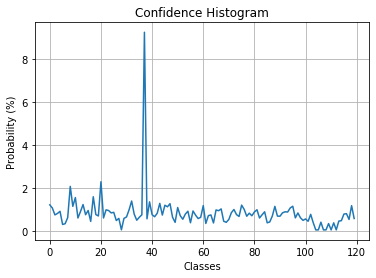

173
Predicted: S121 (6.676)
Expected: S121


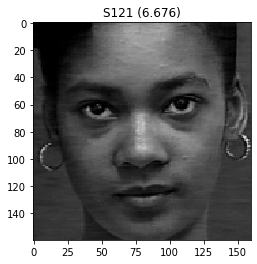

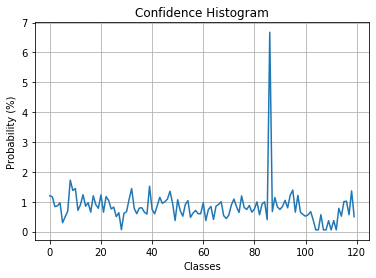

218
Predicted: S110 (15.410)
Expected: S110


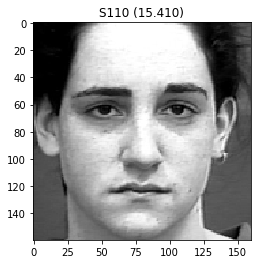

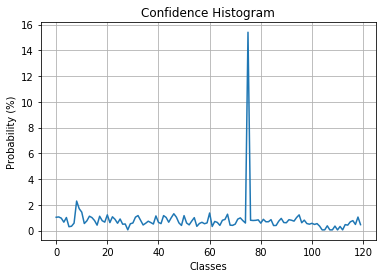

607
Predicted: S080 (10.446)
Expected: S080


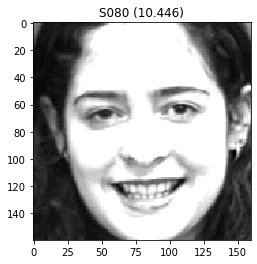

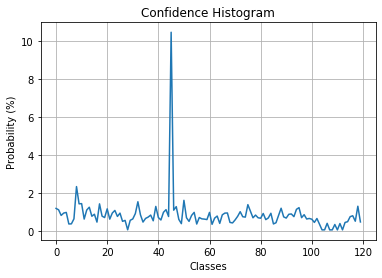

321
Predicted: S129 (14.665)
Expected: S129


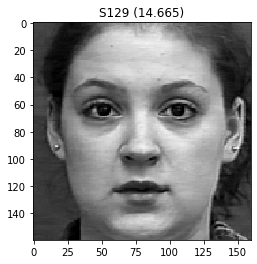

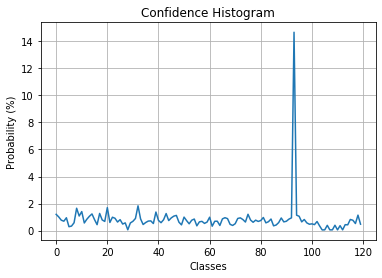

388
Predicted: S114 (11.761)
Expected: S114


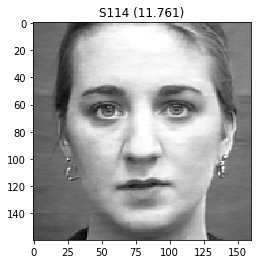

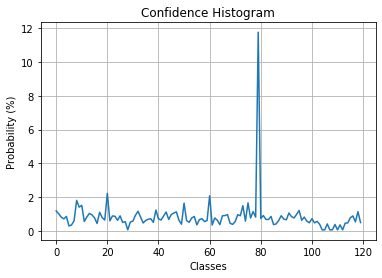

In [8]:
num_runs = 10
for ind in range(num_runs):
    # test model on a random example from the test dataset
    selection = choice([i for i in range(testX.shape[0])])
    print(selection)
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    yhat_prob = model_SVM.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Expected: %s' % random_face_name[0])
    # plot for fun
    pyplot.imshow(random_face_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()
    pyplot.plot(yhat_prob.flatten() * 100)
    pyplot.ylabel("Probability (%)")
    pyplot.xlabel("Classes")
    pyplot.title("Confidence Histogram")
    pyplot.grid()
    pyplot.show()

## Run model on every test set example 

In [9]:
confidences_t = list()
for ind in range(testX.shape[0]):
    # test model on a random example from the test dataset
    selection = ind
    
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    
    yhat_prob = model_SVM.predict_proba(samples)
    

    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    confidences_t.append(class_probability)
    predict_names = out_encoder.inverse_transform(yhat_class)
    if(predict_names[0] == 'S160'):
        print('Predicted: %s (%.3f %%)' % (predict_names[0], class_probability))
        print('Expected: %s' % random_face_name[0])
        # plot for fun
        pyplot.imshow(random_face_pixels)
        title = '%s (%.3f %%)' % (predict_names[0], class_probability)
        pyplot.title(title)


        pyplot.show()
        pyplot.plot(yhat_prob.flatten() * 100)
        x1,x2,y1,y2 = plt.axis()

        plt.axis((x1,x2,y1,100))
        pyplot.ylabel("Probability (%)")
        pyplot.xlabel("Classes")
        pyplot.title("Confidence Histogram")
        pyplot.grid()

        pyplot.show()

In [11]:
confidences_t = [float(i)*100/max(confidences_t) for i in confidences_t]

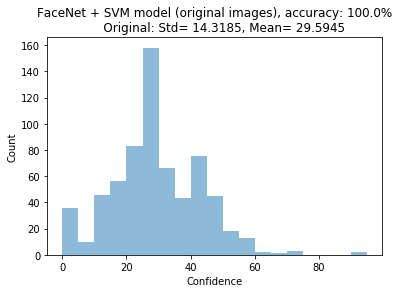

In [13]:
plt.hist(confidences_t, density=False, alpha=0.5, bins=range(0,100,5))
plt.ylabel('Count')
plt.xlabel('Confidence')
plt.title('FaceNet + SVM model (original images), accuracy: {}%\n \
    Original: Std= {}, Mean= {}'.format( yhat_accuracy * 100, 
                                           np.around(np.std(np.asarray(confidences_t)),4),
                                          np.around(np.mean(np.asarray(confidences_t)),4)))
plt.savefig('FaceNet_SVM_original.png')

### The code in this cell is just for analyzing the number of training examples belonging to each class 

In [16]:
y_pred_shape_free_train = model_SVM.predict(trainX)
report = classification_report(trainy, y_pred_shape_free_train, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head(10)

,f1-score,precision,recall,support
0,1.0,1.0,1.0,7.0
1,1.0,1.0,1.0,74.0
2,1.0,1.0,1.0,94.0
3,1.0,1.0,1.0,84.0
4,1.0,1.0,1.0,116.0
5,1.0,1.0,1.0,68.0
6,1.0,1.0,1.0,16.0
7,1.0,1.0,1.0,14.0
8,1.0,1.0,1.0,86.0
9,1.0,1.0,1.0,105.0
